# Final Project (RFM Analysis)

By : Group 2 (Abdurrahman Thaha, Alexander Prasetyo Christianto, Ihsan Aulia Rahman, Maheswara Sinatriyo, Rizky Anshari)

PIC: Maheswara S.

Batch : HCK-001

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pylab as pl
from scipy import stats

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

from feature_engine.outliers import Winsorizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Loading

In [2]:
df_events = pd.read_csv("dsv1069_events.csv")
df_items = pd.read_csv("dsv1069_items.csv")
df_orders = pd.read_csv("dsv1069_orders.csv")
df_users = pd.read_csv("dsv1069_users.csv")

C:\Users\mahes\AppData\Local\Temp\ipykernel_9080\2536878048.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv("dsv1069_events.csv")


In [3]:
df_events.head()

event_id           event_time   user_id event_name  \
0  b9de71c5c3cc4cd7a97e50b832106e5a  2017-06-26 11:23:39  178481.0  view_item   
1  23267713c9ea44419331731f50b6a8db  2017-06-27 10:46:39  178481.0  view_item   
2  1b7822fa7b854e01970218ae8f721fe0  2017-06-27 11:15:39  178481.0  view_item   
3  2a7a188a626841ac94befcc419f06af4  2016-10-05 20:43:10  154133.0  view_item   
4  631d657264cc4616a4528f759509b25d  2016-10-04 03:29:10  154133.0  view_item   

  platform parameter_name parameter_value  
0  android        item_id            3526  
1  android        item_id            1514  
2  android        item_id            3712  
3  android        item_id            3586  
4  android        item_id            1061

events table will not be used for RFM analysis

In [4]:
df_items.head()

adjective     category           created_at      id  \
0                fuzzy  contraption  2014-01-15 21:36:09  2512.0   
1                  NaN   instrument  2013-05-14 05:20:50   482.0   
2  industrial-strength       module  2014-02-04 19:28:32  2446.0   
3              digital         tool  2013-02-25 12:23:18  1312.0   
4            miniature       device  2013-08-05 17:20:45  3556.0   

        modifier                             name  price  
0  carrying_case  fuzzy contraption carrying_case  150.0  
1         refill                instrument refill   35.2  
2            NaN       industrial-strength module  300.0  
3  carrying_case       digital tool carrying_case   16.5  
4        cleaner         miniature device cleaner   16.5

items table will not be used for RFM analysis

In [5]:
df_orders.head()

invoice_id  line_item_id   user_id  item_id  \
0    192320.0       83118.0  178481.0   3526.0   
1    192320.0      207309.0  178481.0   1514.0   
2    192320.0      392027.0  178481.0   3712.0   
3     80902.0      243831.0  154133.0   3586.0   
4     80902.0      399806.0  154133.0   1061.0   

                           item_name item_category  price  \
0                  digital apparatus     apparatus  330.0   
1        miniature apparatus cleaner     apparatus   99.0   
2        miniature apparatus cleaner     apparatus   99.0   
3              reflective instrument    instrument   57.2   
4  extra-strength instrument charger    instrument   17.6   

            created_at              paid_at  
0  2017-06-28 21:14:25  2017-06-27 21:19:39  
1  2017-06-28 21:14:25  2017-06-27 21:19:39  
2  2017-06-28 21:14:25  2017-06-27 21:19:39  
3  2016-10-09 06:57:30  2016-10-07 10:08:10  
4  2016-10-09 06:57:30  2016-10-07 10:08:10

* invoice_id can be used to find total order, 
* user_id for unique id,
* item_id can be used to find total item bought, 
* price for monetary value 
* paid_at for latest transaction

In [6]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47402 entries, 0 to 47401
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invoice_id     47402 non-null  float64
 1   line_item_id   47402 non-null  float64
 2   user_id        47402 non-null  float64
 3   item_id        47402 non-null  float64
 4   item_name      47402 non-null  object 
 5   item_category  47402 non-null  object 
 6   price          47402 non-null  float64
 7   created_at     47402 non-null  object 
 8   paid_at        47402 non-null  object 
dtypes: float64(5), object(4)
memory usage: 3.3+ MB


created_at and paid_at are still object, will be converted to datetime later

In [7]:
df_users.head()

created_at deleted_at               email_address first_name  \
0  2014-12-20 07:07:45        NaN  ArataHopper@earthlink.info      Arata   
1  2016-10-14 05:39:20        NaN    Riya_Gruber1974@mail.net       Riya   
2  2017-01-21 10:20:09        NaN      Peter_Sousa@yahoo.info      Peter   
3  2015-10-30 21:31:30        NaN    D_Kowalski1962@gmail.com          D   
4  2015-10-24 16:27:27        NaN         SNovak1966@mail.com          S   

         id last_name merged_at  parent_user_id  
0   51590.0    Hopper       NaN             NaN  
1  158891.0    Gruber       NaN             NaN  
2  179949.0     Sousa       NaN             NaN  
3   98000.0  Kowalski       NaN             NaN  
4   93994.0     Novak       NaN             NaN

* created_at can be used to find when was the id created

In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117178 entries, 0 to 117177
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   created_at      117178 non-null  object 
 1   deleted_at      2888 non-null    object 
 2   email_address   117178 non-null  object 
 3   first_name      117178 non-null  object 
 4   id              117178 non-null  float64
 5   last_name       117178 non-null  object 
 6   merged_at       6408 non-null    object 
 7   parent_user_id  6408 non-null    float64
dtypes: float64(2), object(6)
memory usage: 7.2+ MB


created at will be converted to datetime

## RFM Analysis

In this RFM analysis we will be doing the following:
* Recency: calculate the length in terms of days, between latest date and last purchase of a customer
* Frequency: calculate the amount of invoice for each customer
* Monetary: calculate the total amount of money spent from a customer
* Length: calculate the total days between the creation of the ID and the latest order of the ID

### Merge Orders and Users

In [9]:
# merge users and orders
new_df = df_orders.merge(df_users,how='inner',left_on="user_id",right_on='id',suffixes=('_orders', '_users'))
new_df

invoice_id  line_item_id   user_id  item_id  \
0        192320.0       83118.0  178481.0   3526.0   
1        192320.0      207309.0  178481.0   1514.0   
2        192320.0      392027.0  178481.0   3712.0   
3         80902.0      243831.0  154133.0   3586.0   
4         80902.0      399806.0  154133.0   1061.0   
...           ...           ...       ...      ...   
47397     92108.0      236314.0  230808.0   1677.0   
47398    348144.0      162528.0  151538.0   3729.0   
47399    348144.0      321219.0  151538.0   1645.0   
47400    348144.0      264112.0  151538.0   2084.0   
47401    348144.0       58354.0  151538.0   2681.0   

                               item_name item_category    price  \
0                      digital apparatus     apparatus  330.000   
1            miniature apparatus cleaner     apparatus   99.000   
2            miniature apparatus cleaner     apparatus   99.000   
3                  reflective instrument    instrument   57.200   
4      extra-strength instrument charger    instrument   17.600   
...                                  ...           ...      ...   
47397                 rechargable widget        widget    3.900   
47398       prize-winning gadget wrapper        gadget   39.160   
47399       digital gadget carrying_case        gadget   58.740   
47400          matte gadget storage_unit        gadget  278.125   
47401             digital gadget charger        gadget   19.580   

         created_at_orders              paid_at     created_at_users  \
0      2017-06-28 21:14:25  2017-06-27 21:19:39  2017-01-02 04:17:55   
1      2017-06-28 21:14:25  2017-06-27 21:19:39  2017-01-02 04:17:55   
2      2017-06-28 21:14:25  2017-06-27 21:19:39  2017-01-02 04:17:55   
3      2016-10-09 06:57:30  2016-10-07 10:08:10  2016-09-09 05:30:45   
4      2016-10-09 06:57:30  2016-10-07 10:08:10  2016-09-09 05:30:45   
...                    ...                  ...                  ...   
47397  2017-12-04 19:01:55  2017-12-05 03:00:14  2017-09-13 08:59:57   
47398  2016-11-18 21:00:07  2016-11-18 14:19:52  2016-09-01 22:55:04   
47399  2016-11-18 21:00:07  2016-11-18 14:19:52  2016-09-01 22:55:04   
47400  2016-11-18 21:00:07  2016-11-18 14:19:52  2016-09-01 22:55:04   
47401  2016-11-18 21:00:07  2016-11-18 14:19:52  2016-09-01 22:55:04   

      deleted_at              email_address first_name        id  last_name  \
0            NaN       ADavis1973@gmail.edu          A  178481.0      Davis   
1            NaN       ADavis1973@gmail.edu          A  178481.0      Davis   
2            NaN       ADavis1973@gmail.edu          A  178481.0      Davis   
3            NaN    Anne_Davis1985@mail.edu       Anne  154133.0      Davis   
4            NaN    Anne_Davis1985@mail.edu       Anne  154133.0      Davis   
...          ...                        ...        ...       ...        ...   
47397        NaN  LisaRodriquez@outlook.edu       Lisa  230808.0  Rodriquez   
47398        NaN      Lisa_Santos@yahoo.net       Lisa  151538.0     Santos   
47399        NaN      Lisa_Santos@yahoo.net       Lisa  151538.0     Santos   
47400        NaN      Lisa_Santos@yahoo.net       Lisa  151538.0     Santos   
47401        NaN      Lisa_Santos@yahoo.net       Lisa  151538.0     Santos   

      merged_at  parent_user_id  
0           NaN             NaN  
1           NaN             NaN  
2           NaN             NaN  
3           NaN             NaN  
4           NaN             NaN  
...         ...             ...  
47397       NaN             NaN  
47398       NaN             NaN  
47399       NaN             NaN  
47400       NaN             NaN  
47401       NaN             NaN  

[47402 rows x 17 columns]

### Drop Unused Columns

In [10]:
# dropping unused columns
new_df.drop(['deleted_at','email_address','first_name','last_name','merged_at','parent_user_id','id','item_name','item_category','line_item_id','created_at_orders'],axis=1,inplace=True)
new_df

invoice_id   user_id  item_id    price              paid_at  \
0        192320.0  178481.0   3526.0  330.000  2017-06-27 21:19:39   
1        192320.0  178481.0   1514.0   99.000  2017-06-27 21:19:39   
2        192320.0  178481.0   3712.0   99.000  2017-06-27 21:19:39   
3         80902.0  154133.0   3586.0   57.200  2016-10-07 10:08:10   
4         80902.0  154133.0   1061.0   17.600  2016-10-07 10:08:10   
...           ...       ...      ...      ...                  ...   
47397     92108.0  230808.0   1677.0    3.900  2017-12-05 03:00:14   
47398    348144.0  151538.0   3729.0   39.160  2016-11-18 14:19:52   
47399    348144.0  151538.0   1645.0   58.740  2016-11-18 14:19:52   
47400    348144.0  151538.0   2084.0  278.125  2016-11-18 14:19:52   
47401    348144.0  151538.0   2681.0   19.580  2016-11-18 14:19:52   

          created_at_users  
0      2017-01-02 04:17:55  
1      2017-01-02 04:17:55  
2      2017-01-02 04:17:55  
3      2016-09-09 05:30:45  
4      2016-09-09 05:30:45  
...                    ...  
47397  2017-09-13 08:59:57  
47398  2016-09-01 22:55:04  
47399  2016-09-01 22:55:04  
47400  2016-09-01 22:55:04  
47401  2016-09-01 22:55:04  

[47402 rows x 6 columns]

### To Datetime

In [11]:
new_df['paid_at'] = pd.to_datetime(new_df['paid_at'])
new_df['created_at_users'] = pd.to_datetime(new_df['created_at_users'])

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47402 entries, 0 to 47401
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   invoice_id        47402 non-null  float64       
 1   user_id           47402 non-null  float64       
 2   item_id           47402 non-null  float64       
 3   price             47402 non-null  float64       
 4   paid_at           47402 non-null  datetime64[ns]
 5   created_at_users  47402 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4)
memory usage: 2.5 MB


### Group By Invoice ID

Grouping by invoice first so that we will not have duplicate invoice later on

In [13]:
# groupby id and agregate other columns
df_agg = new_df.groupby('invoice_id',
            as_index=False).agg(user_id=('user_id',np.max),
                                total_price=('price',np.sum),
                                paid_at=('paid_at',np.max),
                                created_at=('created_at_users',np.min)
                                )
df_agg

invoice_id   user_id  total_price             paid_at  \
0             6.0   89601.0       143.00 2016-03-13 18:38:19   
1            20.0   50878.0       177.22 2015-03-25 03:11:09   
2            30.0   69737.0         0.00 2015-11-08 15:07:15   
3            64.0  139762.0        15.75 2016-12-30 03:33:16   
4            98.0   11072.0       178.64 2014-05-02 03:58:15   
...           ...       ...          ...                 ...   
18966    399938.0  252227.0       300.00 2018-03-13 11:46:58   
18967    399943.0  201699.0      1080.00 2017-05-19 01:51:42   
18968    399960.0   86432.0       105.60 2016-01-30 16:14:37   
18969    399979.0  198052.0        32.04 2017-08-24 11:23:24   
18970    399995.0   64746.0         3.30 2015-08-15 23:53:53   

               created_at  
0     2015-09-14 14:21:56  
1     2014-12-29 08:52:28  
2     2015-05-06 04:36:50  
3     2016-06-20 14:16:04  
4     2013-11-14 14:23:26  
...                   ...  
18966 2017-11-26 22:36:14  
18967 2017-04-23 13:31:26  
18968 2015-08-25 04:06:27  
18969 2017-04-23 08:00:06  
18970 2015-04-01 17:35:45  

[18971 rows x 5 columns]

In [14]:
# counting total item to find the amount of item bought per invoice
total_item = new_df.groupby(['invoice_id'],as_index=False)['item_id'].count()
total_item.rename(columns={'item_id':'total_items'},inplace=True)
total_item.sort_values(by='total_items',ascending=True)

invoice_id  total_items
0             6.0            1
8807     185759.0            1
8806     185747.0            1
8804     185713.0            1
8800     185642.0            1
...           ...          ...
3259      69305.0            4
3258      69297.0            4
13603    286959.0            4
13600    286912.0            4
14147    298778.0            4

[18971 rows x 2 columns]

In [15]:
# merging
by_invoice = df_agg.merge(total_item,how='inner',left_on='invoice_id',right_on='invoice_id')
by_invoice

invoice_id   user_id  total_price             paid_at  \
0             6.0   89601.0       143.00 2016-03-13 18:38:19   
1            20.0   50878.0       177.22 2015-03-25 03:11:09   
2            30.0   69737.0         0.00 2015-11-08 15:07:15   
3            64.0  139762.0        15.75 2016-12-30 03:33:16   
4            98.0   11072.0       178.64 2014-05-02 03:58:15   
...           ...       ...          ...                 ...   
18966    399938.0  252227.0       300.00 2018-03-13 11:46:58   
18967    399943.0  201699.0      1080.00 2017-05-19 01:51:42   
18968    399960.0   86432.0       105.60 2016-01-30 16:14:37   
18969    399979.0  198052.0        32.04 2017-08-24 11:23:24   
18970    399995.0   64746.0         3.30 2015-08-15 23:53:53   

               created_at  total_items  
0     2015-09-14 14:21:56            1  
1     2014-12-29 08:52:28            3  
2     2015-05-06 04:36:50            1  
3     2016-06-20 14:16:04            2  
4     2013-11-14 14:23:26            4  
...                   ...          ...  
18966 2017-11-26 22:36:14            1  
18967 2017-04-23 13:31:26            3  
18968 2015-08-25 04:06:27            3  
18969 2017-04-23 08:00:06            1  
18970 2015-04-01 17:35:45            1  

[18971 rows x 6 columns]

### Group By User ID (Frequency and Monetary)

Counting the invoice per user id to find the Frequency and summing the total price per user id to find the monetary value. changed paid_at to last_order to represent the last date a user made a purchase

In [16]:
# grouping by ID to find Monetary value
by_id = by_invoice.groupby('user_id',as_index=False).agg(
                                Monetary=('total_price',np.sum),
                                last_order=('paid_at',np.max),
                                created_at=('created_at',np.min),
                                Amount=('total_items',np.sum)
                                )
by_id

user_id  Monetary          last_order          created_at  Amount
0          17.0    243.00 2013-05-25 08:27:17 2013-03-03 02:42:42       3
1          25.0      1.80 2013-05-17 03:11:48 2013-03-06 16:01:06       2
2          63.0    585.00 2013-07-07 11:26:45 2013-03-12 16:34:26       3
3          65.0     44.50 2013-05-09 10:22:58 2013-03-08 01:55:17       1
4          69.0      9.42 2013-08-09 23:25:51 2013-02-25 01:26:18       4
...         ...       ...                 ...                 ...     ...
17458  295368.0     45.00 2018-06-01 09:27:57 2018-05-16 20:53:54       1
17459  296332.0      4.65 2018-05-29 22:55:55 2018-05-19 14:15:06       2
17460  296584.0      8.82 2018-06-02 15:15:39 2018-05-17 21:27:18       4
17461  296887.0    144.00 2018-05-29 15:02:38 2018-05-20 06:09:25       4
17462  296956.0    270.56 2018-05-31 09:35:26 2018-05-26 07:39:49       4

[17463 rows x 5 columns]

In [17]:
# counting invoice_id
frequency = by_invoice.groupby('user_id',as_index=False)['invoice_id'].count()
frequency.rename(columns={'invoice_id':'Frequency'},inplace=True)
frequency.sort_values(by='Frequency', ascending=True)

user_id  Frequency
0          17.0          1
11403  176297.0          1
11404  176323.0          1
11405  176325.0          1
11406  176373.0          1
...         ...        ...
12290  191026.0          4
15058  234728.0          4
11763  182241.0          4
5717    88724.0          4
6505   100501.0          4

[17463 rows x 2 columns]

In [18]:
# merging monetary and frequency
df_frequency = by_id.merge(frequency,how='inner',left_on='user_id',right_on='user_id')
df_frequency

user_id  Monetary          last_order          created_at  Amount  \
0          17.0    243.00 2013-05-25 08:27:17 2013-03-03 02:42:42       3   
1          25.0      1.80 2013-05-17 03:11:48 2013-03-06 16:01:06       2   
2          63.0    585.00 2013-07-07 11:26:45 2013-03-12 16:34:26       3   
3          65.0     44.50 2013-05-09 10:22:58 2013-03-08 01:55:17       1   
4          69.0      9.42 2013-08-09 23:25:51 2013-02-25 01:26:18       4   
...         ...       ...                 ...                 ...     ...   
17458  295368.0     45.00 2018-06-01 09:27:57 2018-05-16 20:53:54       1   
17459  296332.0      4.65 2018-05-29 22:55:55 2018-05-19 14:15:06       2   
17460  296584.0      8.82 2018-06-02 15:15:39 2018-05-17 21:27:18       4   
17461  296887.0    144.00 2018-05-29 15:02:38 2018-05-20 06:09:25       4   
17462  296956.0    270.56 2018-05-31 09:35:26 2018-05-26 07:39:49       4   

       Frequency  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
17458          1  
17459          1  
17460          1  
17461          1  
17462          1  

[17463 rows x 6 columns]

### Recency

We will be finding recency by subtracting latest overall date by last_order

In [19]:
# remove timestamp
df_frequency['last_order'] = df_frequency['last_order'].dt.date
df_frequency['created_at'] = df_frequency['created_at'].dt.date
df_frequency

user_id  Monetary  last_order  created_at  Amount  Frequency
0          17.0    243.00  2013-05-25  2013-03-03       3          1
1          25.0      1.80  2013-05-17  2013-03-06       2          1
2          63.0    585.00  2013-07-07  2013-03-12       3          1
3          65.0     44.50  2013-05-09  2013-03-08       1          1
4          69.0      9.42  2013-08-09  2013-02-25       4          1
...         ...       ...         ...         ...     ...        ...
17458  295368.0     45.00  2018-06-01  2018-05-16       1          1
17459  296332.0      4.65  2018-05-29  2018-05-19       2          1
17460  296584.0      8.82  2018-06-02  2018-05-17       4          1
17461  296887.0    144.00  2018-05-29  2018-05-20       4          1
17462  296956.0    270.56  2018-05-31  2018-05-26       4          1

[17463 rows x 6 columns]

In [20]:
# calculating latest purchase
MyList = []
for i in range(len(df_frequency)):
    recent = df_frequency['last_order'].max() - df_frequency['last_order'][i]
    MyList.append(recent)

In [21]:
# df with recency
recency = pd.DataFrame(MyList,columns=["Recency"])
df_recency = pd.concat([df_frequency,recency],axis=1)
df_recency

user_id  Monetary  last_order  created_at  Amount  Frequency   Recency
0          17.0    243.00  2013-05-25  2013-03-03       3          1 1836 days
1          25.0      1.80  2013-05-17  2013-03-06       2          1 1844 days
2          63.0    585.00  2013-07-07  2013-03-12       3          1 1793 days
3          65.0     44.50  2013-05-09  2013-03-08       1          1 1852 days
4          69.0      9.42  2013-08-09  2013-02-25       4          1 1760 days
...         ...       ...         ...         ...     ...        ...       ...
17458  295368.0     45.00  2018-06-01  2018-05-16       1          1    3 days
17459  296332.0      4.65  2018-05-29  2018-05-19       2          1    6 days
17460  296584.0      8.82  2018-06-02  2018-05-17       4          1    2 days
17461  296887.0    144.00  2018-05-29  2018-05-20       4          1    6 days
17462  296956.0    270.56  2018-05-31  2018-05-26       4          1    4 days

[17463 rows x 7 columns]

### Length

In [22]:
# calculating total days as customer
MyList2 = []
for i in range(len(df_recency)):
    days = df_recency['last_order'][i] - df_recency['created_at'][i]
    MyList2.append(days)

In [23]:
length = pd.DataFrame(MyList2,columns=["Length"])
length

Length
0      83 days
1      72 days
2     117 days
3      62 days
4     165 days
...        ...
17458  16 days
17459  10 days
17460  16 days
17461   9 days
17462   5 days

[17463 rows x 1 columns]

In [24]:
# concating length with main dataframe
df_length = pd.concat([df_recency,length],axis=1)
df_length

user_id  Monetary  last_order  created_at  Amount  Frequency  \
0          17.0    243.00  2013-05-25  2013-03-03       3          1   
1          25.0      1.80  2013-05-17  2013-03-06       2          1   
2          63.0    585.00  2013-07-07  2013-03-12       3          1   
3          65.0     44.50  2013-05-09  2013-03-08       1          1   
4          69.0      9.42  2013-08-09  2013-02-25       4          1   
...         ...       ...         ...         ...     ...        ...   
17458  295368.0     45.00  2018-06-01  2018-05-16       1          1   
17459  296332.0      4.65  2018-05-29  2018-05-19       2          1   
17460  296584.0      8.82  2018-06-02  2018-05-17       4          1   
17461  296887.0    144.00  2018-05-29  2018-05-20       4          1   
17462  296956.0    270.56  2018-05-31  2018-05-26       4          1   

        Recency   Length  
0     1836 days  83 days  
1     1844 days  72 days  
2     1793 days 117 days  
3     1852 days  62 days  
4     1760 days 165 days  
...         ...      ...  
17458    3 days  16 days  
17459    6 days  10 days  
17460    2 days  16 days  
17461    6 days   9 days  
17462    4 days   5 days  

[17463 rows x 8 columns]

### RFM Table

In [25]:
# RFM table with user_id
df_RFM = df_length[['user_id','Recency','Frequency','Monetary','Length']]
df_RFM

user_id   Recency  Frequency  Monetary   Length
0          17.0 1836 days          1    243.00  83 days
1          25.0 1844 days          1      1.80  72 days
2          63.0 1793 days          1    585.00 117 days
3          65.0 1852 days          1     44.50  62 days
4          69.0 1760 days          1      9.42 165 days
...         ...       ...        ...       ...      ...
17458  295368.0    3 days          1     45.00  16 days
17459  296332.0    6 days          1      4.65  10 days
17460  296584.0    2 days          1      8.82  16 days
17461  296887.0    6 days          1    144.00   9 days
17462  296956.0    4 days          1    270.56   5 days

[17463 rows x 5 columns]

In [26]:
df_RFM.isna().sum()

user_id      0
Recency      0
Frequency    0
Monetary     0
Length       0
dtype: int64

### RFM EDA

In [27]:
df_RFM[['Recency','Frequency','Monetary','Length']].describe()

Recency     Frequency      Monetary  \
count                        17463  17463.000000  17463.000000   
mean   688 days 19:58:23.521731656      1.086354    276.381676   
std    462 days 06:41:08.242346496      0.299063    383.592673   
min                0 days 00:00:00      1.000000      0.000000   
25%              293 days 00:00:00      1.000000     43.200000   
50%              629 days 00:00:00      1.000000    126.000000   
75%             1035 days 00:00:00      1.000000    338.280000   
max             1908 days 00:00:00      4.000000   4027.500000   

                            Length  
count                        17463  
mean   100 days 14:15:11.595945714  
std     58 days 05:54:31.621686840  
min              -3 days +00:00:00  
25%               50 days 00:00:00  
50%              100 days 00:00:00  
75%              151 days 00:00:00  
max              205 days 00:00:00

We will be doing manual scoring/ranking of the RFML by using quantiles. Lower scores is better, while higher score is of lower performance/rank

In [28]:
RFM_segment = df_RFM.copy()

In [29]:
recency_score = []
for i in range(len(df_RFM)):
    if df_RFM['Recency'][i] <= df_RFM['Recency'].quantile(0.25):
        recency_score.append(1)
    elif df_RFM['Recency'][i] <= df_RFM['Recency'].quantile(0.5):
        recency_score.append(2)
    elif df_RFM['Recency'][i] <= df_RFM['Recency'].quantile(0.75):
        recency_score.append(3)
    else:
        recency_score.append(4)

recency_score = pd.DataFrame(recency_score,columns=["R_score"])
recency_score

R_score
0            4
1            4
2            4
3            4
4            4
...        ...
17458        1
17459        1
17460        1
17461        1
17462        1

[17463 rows x 1 columns]

In [30]:
frequency_score = []
for i in range(len(df_RFM)):
    if df_RFM['Frequency'][i] <= df_RFM['Frequency'].quantile(0.25):
        frequency_score.append(4)
    elif df_RFM['Frequency'][i] <= df_RFM['Frequency'].quantile(0.5):
        frequency_score.append(3)
    elif df_RFM['Frequency'][i] <= df_RFM['Frequency'].quantile(0.75):
        frequency_score.append(2)
    else:
        frequency_score.append(1)

frequency_score = pd.DataFrame(frequency_score,columns=["F_score"])
frequency_score

F_score
0            4
1            4
2            4
3            4
4            4
...        ...
17458        4
17459        4
17460        4
17461        4
17462        4

[17463 rows x 1 columns]

In [31]:
monetary_score = []
for i in range(len(df_RFM)):
    if df_RFM['Monetary'][i] <= df_RFM['Monetary'].quantile(0.25):
        monetary_score.append(4)
    elif df_RFM['Monetary'][i] <= df_RFM['Monetary'].quantile(0.5):
        monetary_score.append(3)
    elif df_RFM['Monetary'][i] <= df_RFM['Monetary'].quantile(0.75):
        monetary_score.append(2)
    else:
        monetary_score.append(1)

monetary_score = pd.DataFrame(monetary_score,columns=["M_score"])
monetary_score

M_score
0            2
1            4
2            1
3            3
4            4
...        ...
17458        3
17459        4
17460        4
17461        2
17462        2

[17463 rows x 1 columns]

In [32]:
length_score = []
for i in range(len(df_RFM)):
    if df_RFM['Length'][i] <= df_RFM['Length'].quantile(0.25):
        length_score.append(4)
    elif df_RFM['Length'][i] <= df_RFM['Length'].quantile(0.5):
        length_score.append(3)
    elif df_RFM['Length'][i] <= df_RFM['Length'].quantile(0.75):
        length_score.append(2)
    else:
        length_score.append(1)

length_score = pd.DataFrame(length_score,columns=["L_score"])
length_score

L_score
0            3
1            3
2            2
3            3
4            1
...        ...
17458        4
17459        4
17460        4
17461        4
17462        4

[17463 rows x 1 columns]

In [33]:
# manual segment by combining the score
segments = []
for i in range(len(df_RFM)):
    n = str(recency_score['R_score'][i]) + str(frequency_score['F_score'][i]) + str(monetary_score['M_score'][i]) + str(length_score['L_score'][i])
    segments.append(n)

segments = pd.DataFrame(segments,columns=["RFM_segment"])
segments

RFM_segment
0            4423
1            4443
2            4412
3            4433
4            4441
...           ...
17458        1434
17459        1444
17460        1444
17461        1424
17462        1424

[17463 rows x 1 columns]

To segment the user manually we will be combining the RFM scores into a new segment. But this will results in a lot of segments thus we will be picking important segment later.

In [34]:
scores = []
for i in range(len(df_RFM)):
    n = recency_score['R_score'][i] + frequency_score['F_score'][i] + monetary_score['M_score'][i] + length_score['L_score'][i]
    scores.append(n)

scores = pd.DataFrame(scores,columns=["RFM_score"])
scores

RFM_score
0             13
1             15
2             11
3             14
4             13
...          ...
17458         12
17459         13
17460         13
17461         11
17462         11

[17463 rows x 1 columns]

In [35]:
RFM_segment = pd.concat([df_RFM,recency_score,frequency_score,monetary_score,length_score,segments,scores],axis=1)
RFM_segment

user_id   Recency  Frequency  Monetary   Length  R_score  F_score  \
0          17.0 1836 days          1    243.00  83 days        4        4   
1          25.0 1844 days          1      1.80  72 days        4        4   
2          63.0 1793 days          1    585.00 117 days        4        4   
3          65.0 1852 days          1     44.50  62 days        4        4   
4          69.0 1760 days          1      9.42 165 days        4        4   
...         ...       ...        ...       ...      ...      ...      ...   
17458  295368.0    3 days          1     45.00  16 days        1        4   
17459  296332.0    6 days          1      4.65  10 days        1        4   
17460  296584.0    2 days          1      8.82  16 days        1        4   
17461  296887.0    6 days          1    144.00   9 days        1        4   
17462  296956.0    4 days          1    270.56   5 days        1        4   

       M_score  L_score RFM_segment  RFM_score  
0            2        3        4423         13  
1            4        3        4443         15  
2            1        2        4412         11  
3            3        3        4433         14  
4            4        1        4441         13  
...        ...      ...         ...        ...  
17458        3        4        1434         12  
17459        4        4        1444         13  
17460        4        4        1444         13  
17461        2        4        1424         11  
17462        2        4        1424         11  

[17463 rows x 11 columns]

Final results of RFM score and segmentation table

<AxesSubplot:xlabel='RFM_score', ylabel='count'>

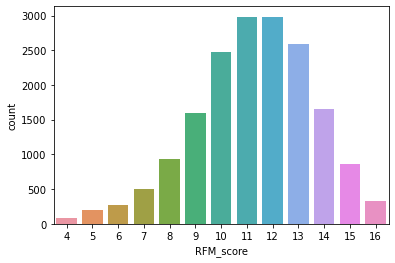

In [36]:
sns.countplot(RFM_segment['RFM_score'])

Based on the plot, most users have low score between 10 and 13. While the amount of users with good score (6 and below) is very small. This indicates that the company is not performing well since in general the users have bad segment score. 

In [37]:
print("Best Customers: ",len(RFM_segment[RFM_segment['RFM_segment']=='1111']))
print('Loyal Customers: ',len(RFM_segment[RFM_segment['F_score']==1]))
print("Big Spenders: ",len(RFM_segment[RFM_segment['M_score']==1]))
print('Lost Customers: ',len(RFM_segment[RFM_segment['RFM_segment']=='4444']))

Best Customers:  87
Loyal Customers:  1421
Big Spenders:  4366
Lost Customers:  323


In [38]:
RFM_segment.describe()

user_id                      Recency     Frequency      Monetary  \
count   17463.000000                        17463  17463.000000  17463.000000   
mean   135718.863712  688 days 19:58:23.521731656      1.086354    276.381676   
std     79185.618598  462 days 06:41:08.242346496      0.299063    383.592673   
min        17.000000              0 days 00:00:00      1.000000      0.000000   
25%     67112.000000            293 days 00:00:00      1.000000     43.200000   
50%    134184.000000            629 days 00:00:00      1.000000    126.000000   
75%    203160.000000           1035 days 00:00:00      1.000000    338.280000   
max    296956.000000           1908 days 00:00:00      4.000000   4027.500000   

                            Length       R_score       F_score       M_score  \
count                        17463  17463.000000  17463.000000  17463.000000   
mean   100 days 14:15:11.595945714      2.498597      3.755884      2.500601   
std     58 days 05:54:31.621686840      1.118091      0.820240      1.118245   
min              -3 days +00:00:00      1.000000      1.000000      1.000000   
25%               50 days 00:00:00      1.000000      4.000000      1.500000   
50%              100 days 00:00:00      2.000000      4.000000      3.000000   
75%              151 days 00:00:00      3.000000      4.000000      4.000000   
max              205 days 00:00:00      4.000000      4.000000      4.000000   

            L_score     RFM_score  
count  17463.000000  17463.000000  
mean       2.506156     11.261238  
std        1.118996      2.302541  
min        1.000000      4.000000  
25%        2.000000     10.000000  
50%        3.000000     11.000000  
75%        4.000000     13.000000  
max        4.000000     16.000000

Quick overview:
* **Recency**: In general the Recency of the users are very bad since the Q1 of the recency is almost a year and the Q2 is almost 2 years. Furthermore the average user bought an item 2 years ago and has never made any purchase since.
* **Frequency**: The frequency of most users are also very bad as the Q1-Q3 is 1 transaction, which mean the majority of the users only made 1 transaction in the past 5 years.
* **Monetary**: The monetary is well distributed for the Q1-Q3, but it has extreme outliers that are more than 10x the value of Q3. 
* **Length**: The average age of an account is 100 days (From the day it was created until its last purchase). There seems to be anomaly as well since some account has negatie age, which means that the last purchase happens before the account was created. This is likely happen due to input errors, but we can ignore it for now since the difference is not that far from 0.

In [39]:
RFM_segment['R_score'].value_counts()

1    4373
2    4369
3    4362
4    4359
Name: R_score, dtype: int64

The segment for R score are well distributed

In [40]:
RFM_segment['F_score'].value_counts()

4    16042
1     1421
Name: F_score, dtype: int64

In [41]:
RFM_segment['Frequency'].value_counts()

1    16042
2     1339
3       77
4        5
Name: Frequency, dtype: int64

In [42]:
print("One time users: ", (16042/(16042+1412))*100)

One time users:  91.91016385928727


We can see that the majority of users (92%) only made 1 purchase and is scored as 4, any users that made more than 1 purchase are considered as rank 1.

In [43]:
RFM_segment['M_score'].value_counts()

3    4370
4    4369
1    4366
2    4358
Name: M_score, dtype: int64

Despite the extreme outliers, since we are using Quartile to define the segment/score, the Monetary score is well distributed

In [44]:
RFM_segment['L_score'].value_counts()

4    4421
2    4387
1    4329
3    4326
Name: L_score, dtype: int64

Length score are also well distributed

In [45]:
RFM_segment['RFM_segment'].nunique()

126

As we can see that there are 126 unique segment, defining all the segment manually would take a lot of time and effort. Thus we will be using unsupervised machine learning to cluster the users with less number of segments.

## Preprocessing

In [46]:
# making a segment only with user id table for later plot
segment_only = RFM_segment[['user_id','R_score','F_score','M_score','L_score']]
segment_only.rename({'R_score':'Recency','F_score':'Frequency','M_score':'Monetary','L_score':'Length'},axis=1,inplace=True)
segment_only

C:\Users\mahes\AppData\Local\Temp\ipykernel_9080\4214220893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_only.rename({'R_score':'Recency','F_score':'Frequency','M_score':'Monetary','L_score':'Length'},axis=1,inplace=True)


user_id  Recency  Frequency  Monetary  Length
0          17.0        4          4         2       3
1          25.0        4          4         4       3
2          63.0        4          4         1       2
3          65.0        4          4         3       3
4          69.0        4          4         4       1
...         ...      ...        ...       ...     ...
17458  295368.0        1          4         3       4
17459  296332.0        1          4         4       4
17460  296584.0        1          4         4       4
17461  296887.0        1          4         2       4
17462  296956.0        1          4         2       4

[17463 rows x 5 columns]

In [47]:
df_preprocess = df_RFM.copy()
df_preprocess.drop('user_id',axis=1,inplace=True)
df_preprocess['Recency'] = df_preprocess['Recency'].dt.days
df_preprocess['Length'] = df_preprocess['Length'].dt.days
df_preprocess

Recency  Frequency  Monetary  Length
0         1836          1    243.00      83
1         1844          1      1.80      72
2         1793          1    585.00     117
3         1852          1     44.50      62
4         1760          1      9.42     165
...        ...        ...       ...     ...
17458        3          1     45.00      16
17459        6          1      4.65      10
17460        2          1      8.82      16
17461        6          1    144.00       9
17462        4          1    270.56       5

[17463 rows x 4 columns]

In [48]:
df_preprocess.skew()

Recency      0.421688
Frequency    3.584792
Monetary     2.698717
Length       0.009375
dtype: float64

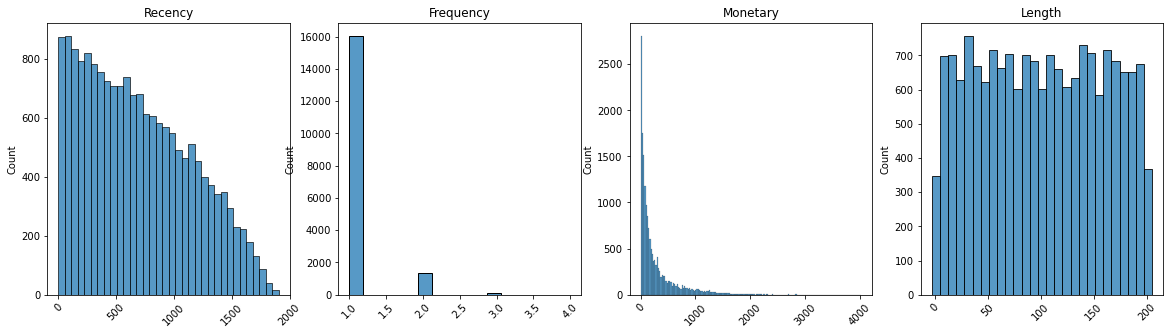

In [49]:
plt.figure(figsize=(20,5))
for i,c in enumerate(df_preprocess):
    plt.subplot(1,4,i+1)
    sns.histplot(df_preprocess[c])
    plt.title(c)
    plt.xlabel('')
    plt.xticks(rotation=45)

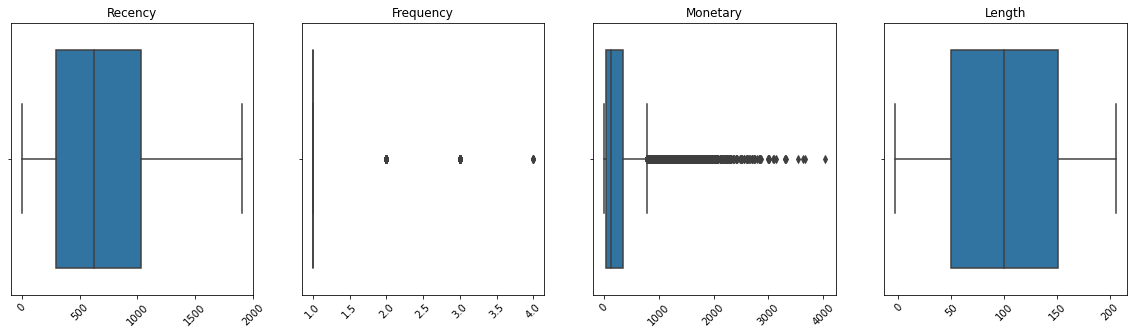

In [50]:
plt.figure(figsize=(20,5))
for i,c in enumerate(df_preprocess):
    plt.subplot(1,4,i+1)
    sns.boxplot(df_preprocess[c])
    plt.title(c)
    plt.xlabel('')
    plt.xticks(rotation=45)

As we can see from skew, histplot, and boxplot both Frequency and Monetary are extremely skewed. Thus we will be handling these outliers using winsorizer.

### Outlier Handling

In [51]:
# winsorizer
winsorizer = Winsorizer(capping_method='iqr',
                          tail='right', 
                          fold=1.5,
                          variables=['Monetary','Frequency'])

winsorizer.fit(df_preprocess)

df_win = winsorizer.transform(df_preprocess)                      

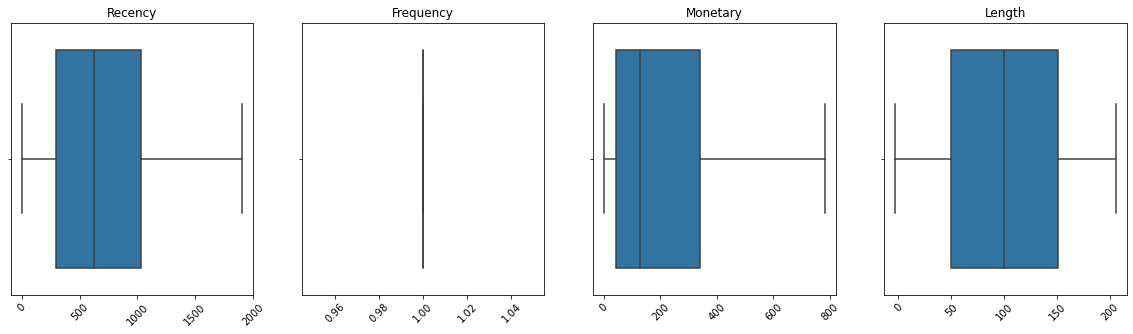

In [52]:
plt.figure(figsize=(20,5))
for i,c in enumerate(df_win):
    plt.subplot(1,4,i+1)
    sns.boxplot(df_win[c])
    plt.title(c)
    plt.xlabel('')
    plt.xticks(rotation=45)

No more outliers

### Scaling

In [53]:
scale = StandardScaler()

In [54]:
df_scale = scale.fit_transform(df_win)

df_fin = pd.DataFrame()
df_fin['Recency'] = pd.DataFrame(df_scale[:,0])
df_fin['Frequency'] = pd.DataFrame(df_scale[:,1])
df_fin['Monetary'] = pd.DataFrame(df_scale[:,2])
df_fin['Length'] = pd.DataFrame(df_scale[:,3])


df_fin

Recency  Frequency  Monetary    Length
0      2.481622        0.0  0.041298 -0.302069
1      2.498928        0.0 -0.922969 -0.490928
2      2.388602        0.0  1.408543  0.281676
3      2.516234        0.0 -0.752263 -0.662618
4      2.317214        0.0 -0.892506  1.105788
...         ...        ...       ...       ...
17458 -1.483633        0.0 -0.750264 -1.452392
17459 -1.477143        0.0 -0.911575 -1.555406
17460 -1.485797        0.0 -0.894905 -1.452392
17461 -1.477143        0.0 -0.354483 -1.572575
17462 -1.481470        0.0  0.151477 -1.641251

[17463 rows x 4 columns]

### Concat

In [55]:
df_use = df_fin.copy()

### PCA

In [56]:
pca = PCA(n_components=2).fit(df_use)

In [57]:
pca.explained_variance_ratio_

array([0.35589124, 0.32823754])

In [58]:
df_pca = pca.transform(df_use)

## Modeling

### K means

In [59]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=99).fit(df_fin)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(df_use, model.labels_)
                     for model in kmeans_per_k[1:]]

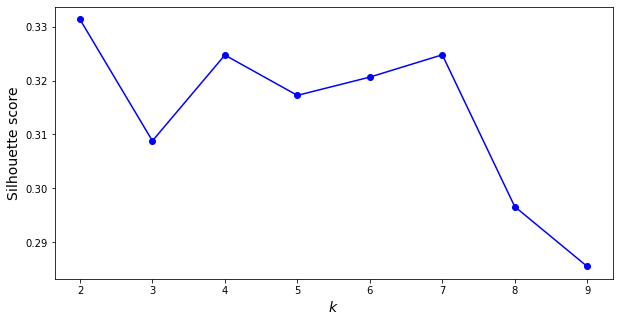

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

Based on the silhouette score, k = 4 and 7 are the optimal cluster. But 7 cluster might be too much segmentation for this dataset.

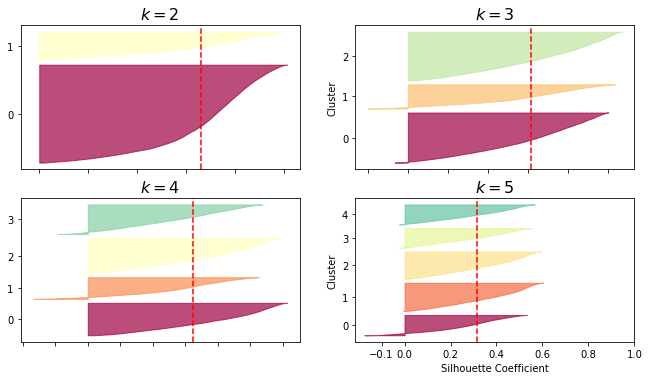

In [62]:
plt.figure(figsize=(11, 9))

for k in (2,3,4,5):
    plt.subplot(3,2,k-1)

    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(df_use, y_pred)

    padding = len(df_use) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = pl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
        facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3,5):
        plt.ylabel('Cluster')
    if k in (5,10):
        plt.gca().set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
        plt.xlabel('Silhouette Coefficient')
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k-2], color='red', linestyle='--')
    plt.title('$k={}$'.format(k), fontsize=16)

plt.show()

Based on the silhouette visualization, we should be able to find the best k value by considering the following:
* All cluster are above the red line
* Minimal tail are better
* Same size cluster are better

Based on that, cluster 4 and 5 are a good option

In [63]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df_use) 
    kmeanModel.fit(df_use)     
      
    distortions.append(sum(np.min(cdist(df_use, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_use.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_use, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_use.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

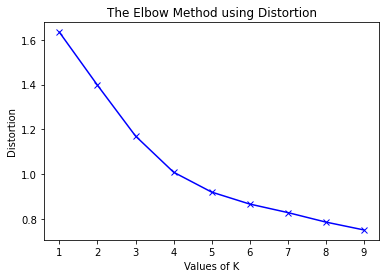

In [64]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

Based on the distortion, the best elbow would be from k = 4 or 5

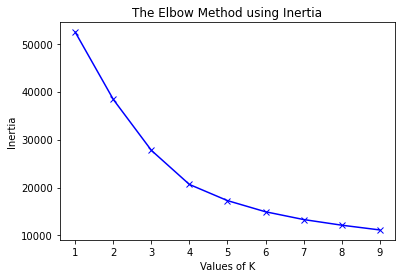

In [65]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Similar with distortion, the best elbow would be from k = 4 or 5

Overall, The best clustering would come from 4 cluster

In [66]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

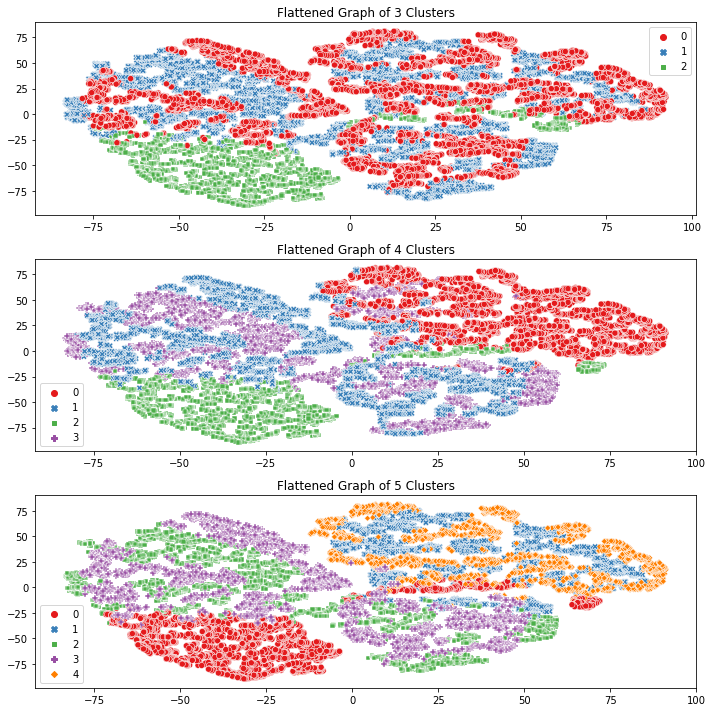

In [67]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(df_use, 3, df_preprocess)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(df_use, 4, df_preprocess)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(df_use, 5, df_preprocess)

plt.tight_layout()
# plt.savefig('flattened.png', format='png', dpi=1000)

* 3 cluster can't seems to differentiate between 0 and 1. Only cluster lable 2 correctly
* 4 cluster able to correctly lable 0 and 2. Lable 1 and 3 is a bit mixed
* 5 cluster can only lable 0 correctly, 1 and 4 are mixed, 2 and 3 are mixed

In [68]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_RFM.index, 
                                       columns=df_RFM.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['user_id', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary','Length'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

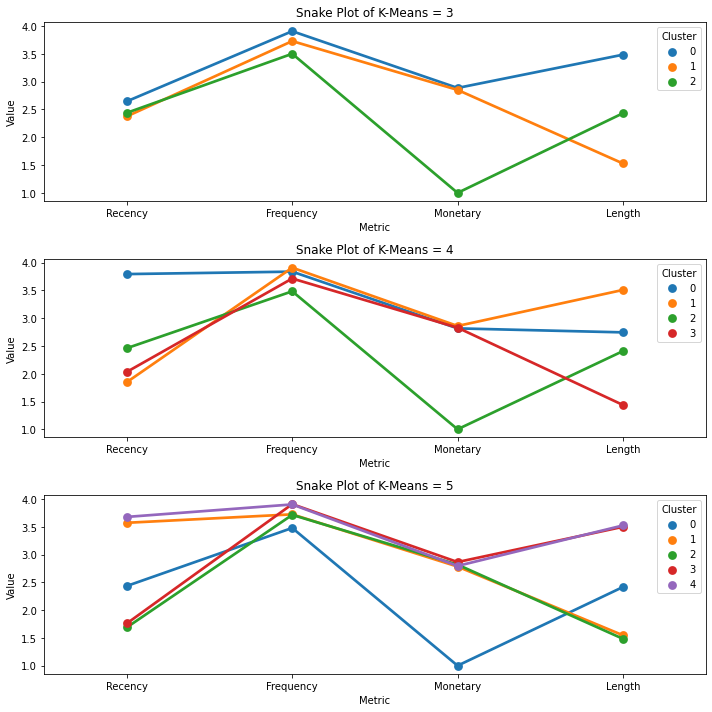

In [69]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(segment_only, df_rfm_k3) 

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(segment_only, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(segment_only, df_rfm_k5)

plt.tight_layout()

Based on the sanke plot for K means 4 cluster has the best result on differentiating the clusters

### Gaussian Mixture Full

In [70]:
def gaussian_full(normalised_df_rfm, clusters_number, original_df_rfm):
    
    gaussian = GaussianMixture(n_components = clusters_number, covariance_type='full')
    gaussian.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = gaussian.predict(normalised_df_rfm)
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

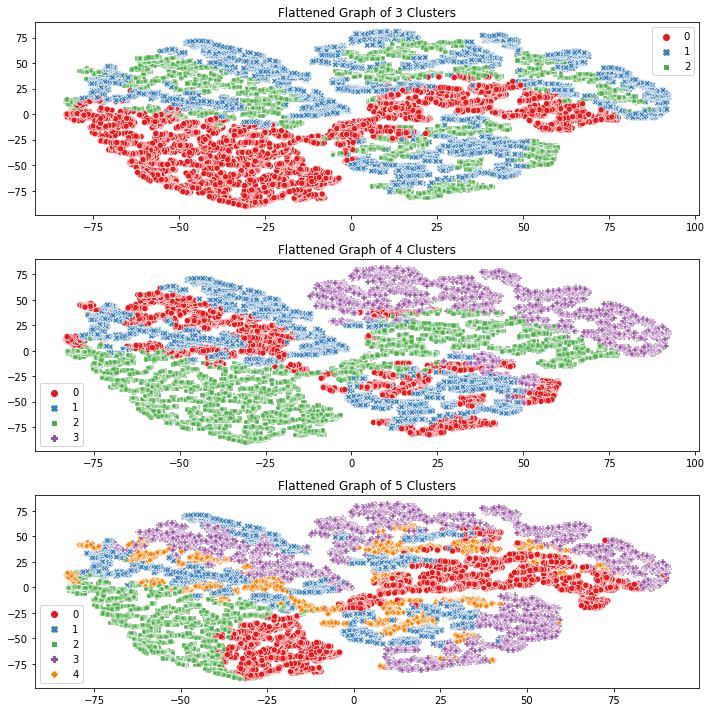

In [71]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = gaussian_full(df_use, 3, df_preprocess)

plt.subplot(3, 1, 2)
df_rfm_k4 = gaussian_full(df_use, 4, df_preprocess)

plt.subplot(3, 1, 3)
df_rfm_k5 = gaussian_full(df_use, 5, df_preprocess)

plt.tight_layout()
# plt.savefig('flattened.png', format='png', dpi=1000)

Based on the plot, the model is has better clustering at 3 cluster

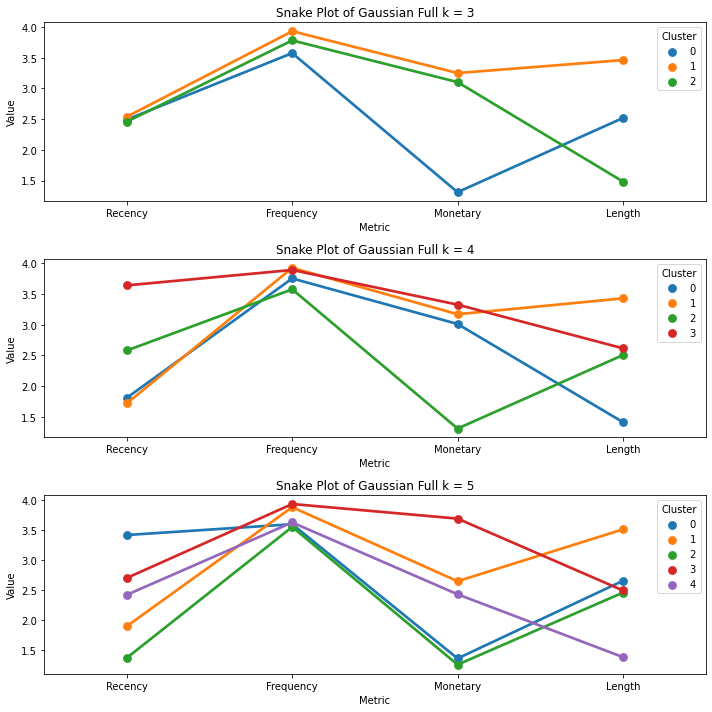

In [72]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of Gaussian Full k = 3')
snake_plot(segment_only, df_rfm_k3) 

plt.subplot(3, 1, 2)
plt.title('Snake Plot of Gaussian Full k = 4')
snake_plot(segment_only, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of Gaussian Full k = 5')
snake_plot(segment_only, df_rfm_k5)

plt.tight_layout()

But based on the sanke plot, the model cant differentiate the length of a users. Thus based on the snake plot 4 cluster is better since the model can differentiate the recency and length better

### Gaussian Mixture Spherical

In [73]:
def gaussian_sphere(normalised_df_rfm, clusters_number, original_df_rfm):
    
    gaussian = GaussianMixture(n_components = clusters_number, covariance_type='spherical')
    gaussian.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = gaussian.predict(normalised_df_rfm)
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

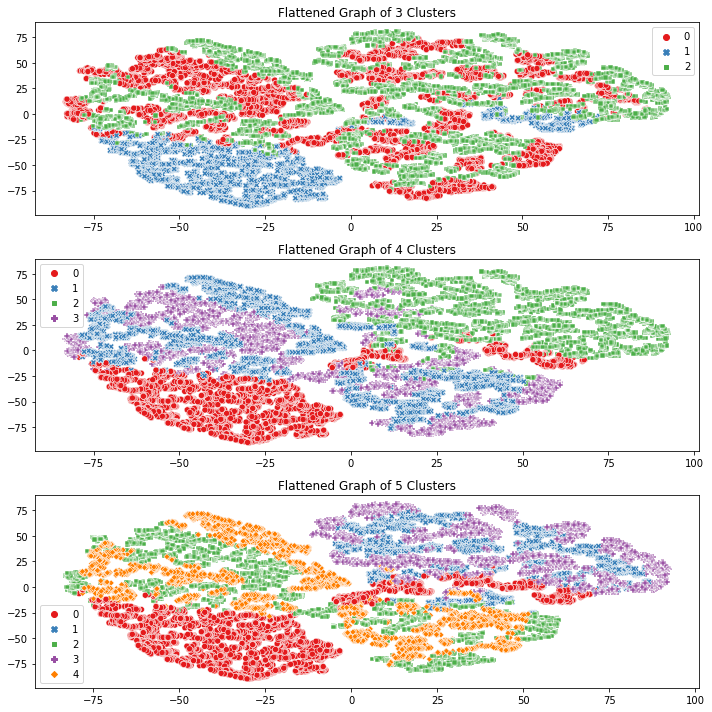

In [74]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = gaussian_sphere(df_use, 3, df_preprocess)

plt.subplot(3, 1, 2)
df_rfm_k4 = gaussian_sphere(df_use, 4, df_preprocess)

plt.subplot(3, 1, 3)
df_rfm_k5 = gaussian_sphere(df_use, 5, df_preprocess)

plt.tight_layout()
# plt.savefig('flattened.png', format='png', dpi=1000)

Based on the plot for gaussian mixture spherical the best cluster are 4 clusters

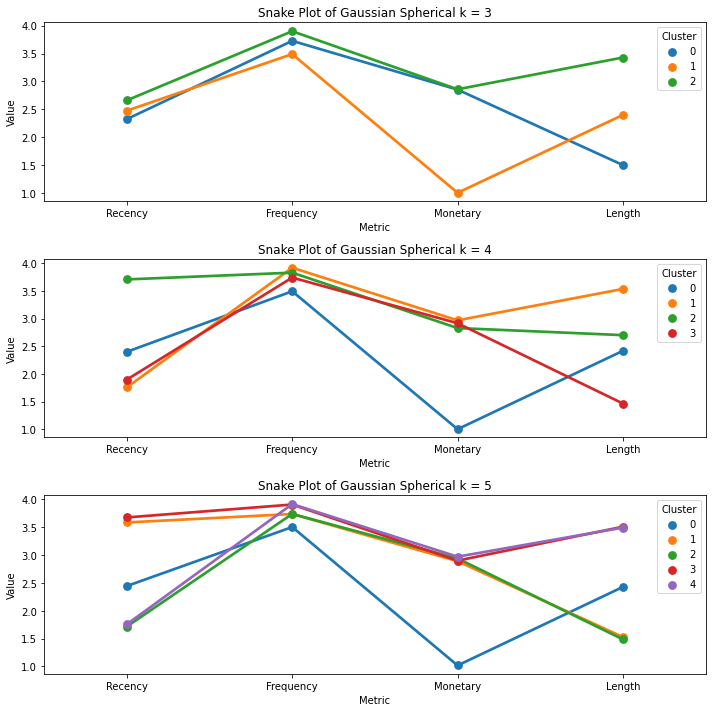

In [75]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of Gaussian Spherical k = 3')
snake_plot(segment_only, df_rfm_k3) 

plt.subplot(3, 1, 2)
plt.title('Snake Plot of Gaussian Spherical k = 4')
snake_plot(segment_only, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of Gaussian Spherical k = 5')
snake_plot(segment_only, df_rfm_k5)

plt.tight_layout()

The snakeplot also shows that 4 cluster has the best differentiating cluster compared to 3 and 5 clusters.

### Gaussian Mixture Tied

In [76]:
def gaussian_tied(normalised_df_rfm, clusters_number, original_df_rfm):
    
    gaussian = GaussianMixture(n_components = clusters_number, covariance_type='tied')
    gaussian.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = gaussian.predict(normalised_df_rfm)
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

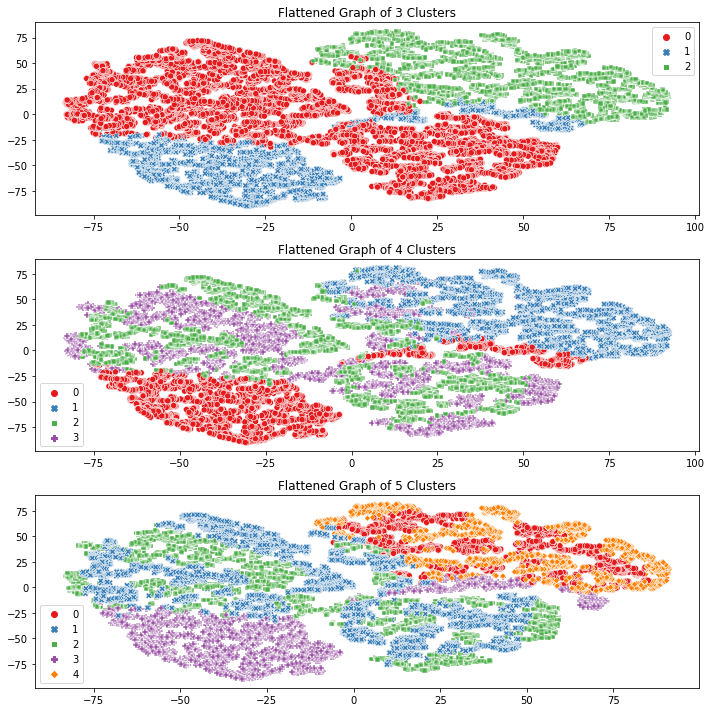

In [77]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = gaussian_tied(df_use, 3, df_preprocess)

plt.subplot(3, 1, 2)
df_rfm_k4 = gaussian_tied(df_use, 4, df_preprocess)

plt.subplot(3, 1, 3)
df_rfm_k5 = gaussian_tied(df_use, 5, df_preprocess)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

Gaussian tied has a very good cluster result with 3 cluster based on the plot.

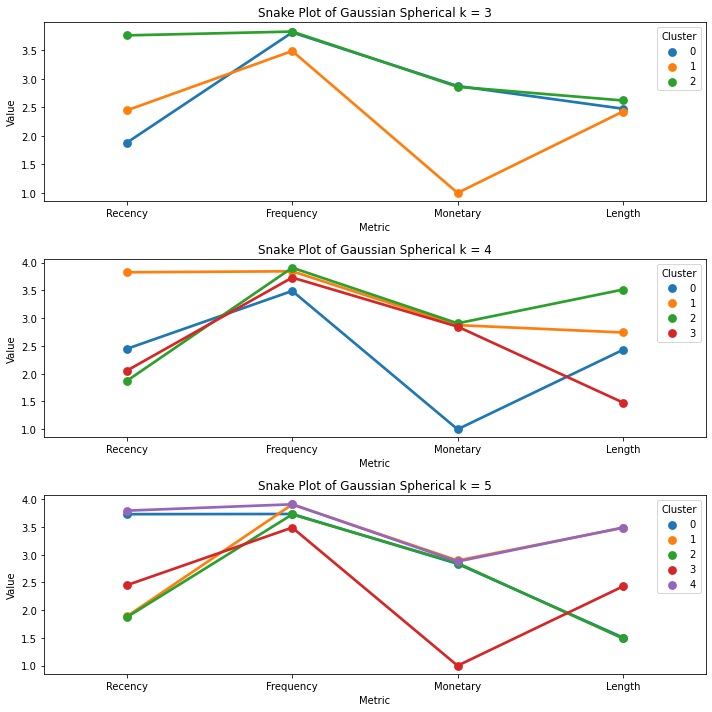

In [78]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of Gaussian Spherical k = 3')
snake_plot(segment_only, df_rfm_k3) 

plt.subplot(3, 1, 2)
plt.title('Snake Plot of Gaussian Spherical k = 4')
snake_plot(segment_only, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of Gaussian Spherical k = 5')
snake_plot(segment_only, df_rfm_k5)

plt.tight_layout()

But again based on the snakeplot 3 cluster can't differentiate between the length of a customer.

### Spectral Clustering

In [79]:
def spectral(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = SpectralClustering(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

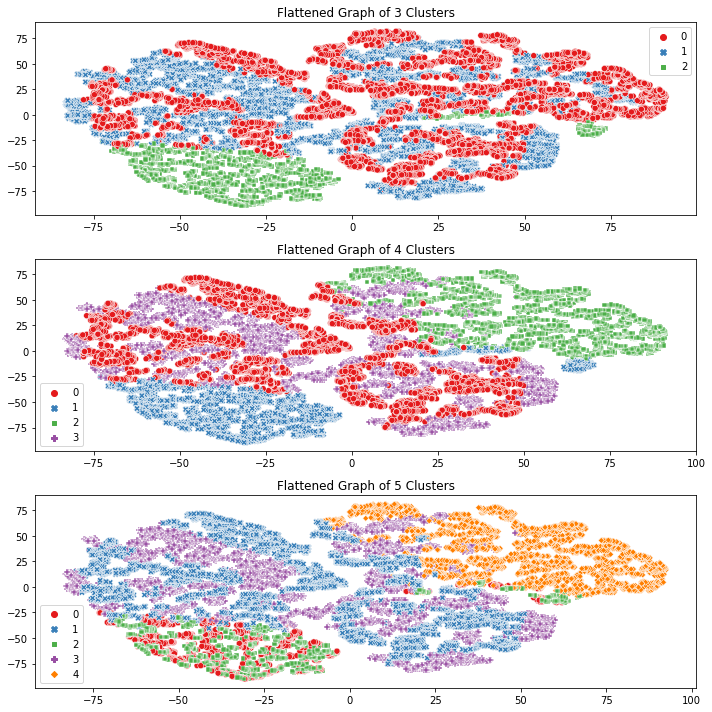

In [80]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = spectral(df_use, 3, df_preprocess)

plt.subplot(3, 1, 2)
df_rfm_k4 = spectral(df_use, 4, df_preprocess)

plt.subplot(3, 1, 3)
df_rfm_k5 = spectral(df_use, 5, df_preprocess)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

Based on the plot the best cluster for spectral clustering is 4 cluster.

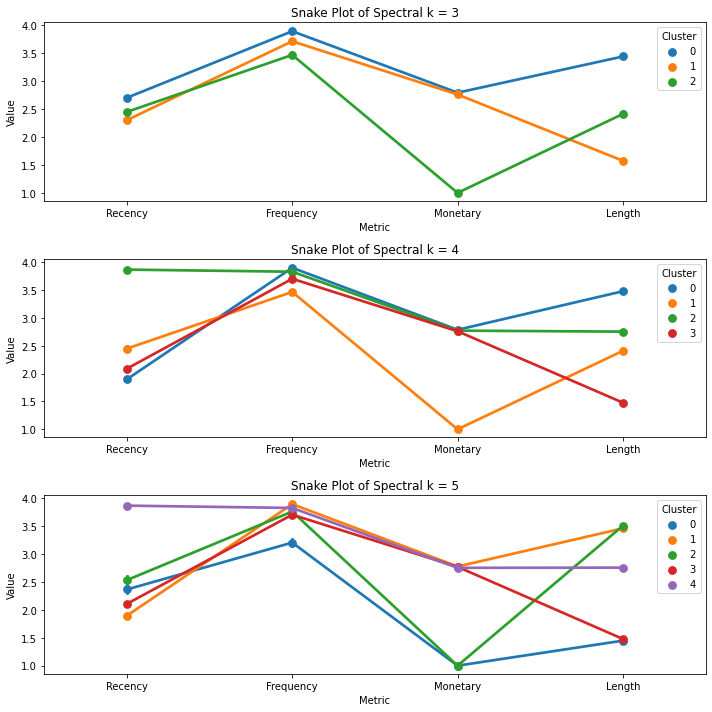

In [81]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of Spectral k = 3')
snake_plot(segment_only, df_rfm_k3) 

plt.subplot(3, 1, 2)
plt.title('Snake Plot of Spectral k = 4')
snake_plot(segment_only, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of Spectral k = 5')
snake_plot(segment_only, df_rfm_k5)

plt.tight_layout()

Based on the snake plot, the model does have a better results at clustering with 4 cluster as tit can differentiate both recency and length.

Overall, we found that the majority of the models perform best with 4 cluster. But oerall K-means with 4 cluster is the better option (by a slight margin) compared to the other model as most of them performs similarly with 4 clusters.

## Best Model

In [82]:
# plt.figure(figsize=(10, 10))

# plt.subplot(2, 1, 1)
# df_rfm_best = kmeans(df_use, 4, df_preprocess)

# plt.subplot(2, 1, 2)
# plt.title('Snake Plot of K-means = 4')
# snake_plot(segment_only, df_rfm_best)

# plt.tight_layout()
# plt.savefig('flattened.png', format='png', dpi=1000)

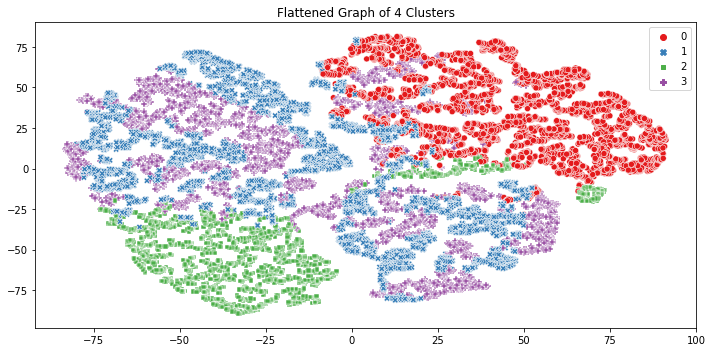

In [83]:
plt.figure(figsize=(10, 5))

df_rfm_best = kmeans(df_use, 4, df_preprocess)

plt.tight_layout()
plt.savefig('Cluster.png', format='png', dpi=1000)

Based on the clustering, the model is able to differentiate 0 and 2 distinctly. But cluster 1 and 3 is a bit mixed, we will explore further in the snakeplot.

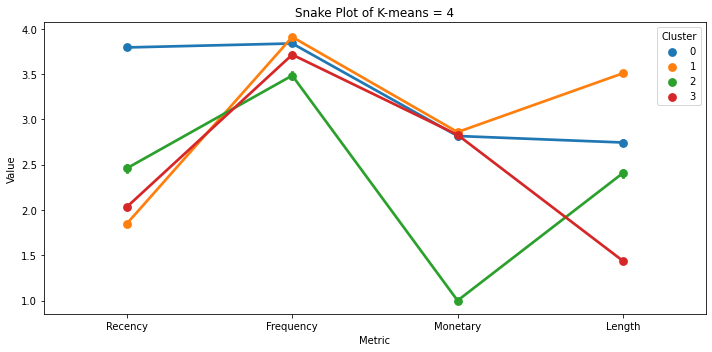

In [84]:
plt.figure(figsize=(10, 5))

plt.title('Snake Plot of K-means = 4')
snake_plot(segment_only, df_rfm_best)

plt.tight_layout()
plt.savefig('Snakeplot.png', format='png', dpi=1000)

Overall this is our best clustering model. This model can distincly differentiate cluster 0 and 2, while the differentiating factor of cluster 1 and 3 is the length (how long the accoun has been active for).

K means 4:
* 0. Hybernating: Low score (close to 4) on all features except length (indicates old user that has been inactive)
* 1. New Customer: Recent purchase, lowest frequency, lowest spending, shortest account time
* 2. Potential Loyalist: Good recency, best frequency, high spenders, decent length
* 3. Loyal Customer: Longest user with recent purchase, decent frequency and decent spending

In [85]:
newList = []

for i in range(len(df_rfm_best)):
    if df_rfm_best['Cluster'][i] == 0:
        newList.append('Hybernating')
    elif df_rfm_best['Cluster'][i] == 1:
        newList.append('New Customer')
    elif df_rfm_best['Cluster'][i] == 2:
        newList.append('Potential Loyalist')
    else:
        newList.append('Loyal Customer')

new_cluster = pd.DataFrame(newList,columns=['Segment'])

df_cluster_rfm = pd.concat([df_preprocess,new_cluster],axis=1)
df_cluster_score = pd.concat([segment_only,new_cluster],axis=1)
df_cluster_score

user_id  Recency  Frequency  Monetary  Length       Segment
0          17.0        4          4         2       3   Hybernating
1          25.0        4          4         4       3   Hybernating
2          63.0        4          4         1       2   Hybernating
3          65.0        4          4         3       3   Hybernating
4          69.0        4          4         4       1   Hybernating
...         ...      ...        ...       ...     ...           ...
17458  295368.0        1          4         3       4  New Customer
17459  296332.0        1          4         4       4  New Customer
17460  296584.0        1          4         4       4  New Customer
17461  296887.0        1          4         2       4  New Customer
17462  296956.0        1          4         2       4  New Customer

[17463 rows x 6 columns]

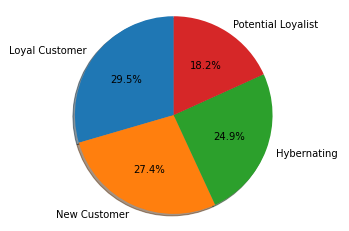

In [86]:
fig1, ax1 = plt.subplots()
ax1.pie(df_cluster_score['Segment'].value_counts(), labels=df_cluster_score['Segment'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Based on the distribution, we can see that cluster Loyal Customer has the most users at 29.5% of total users, while Potential Loyalist has the lowest total user taking up around 18.2% of total users.

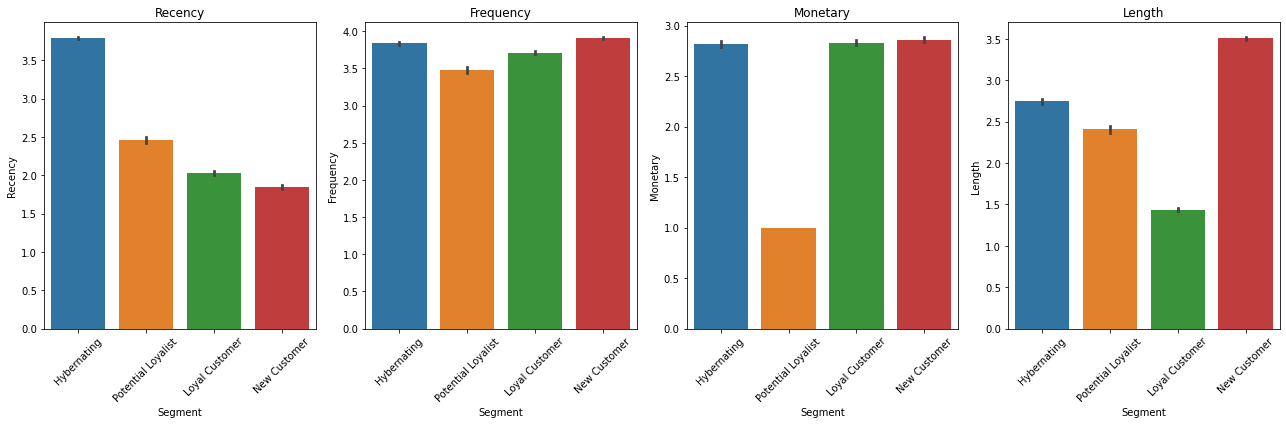

In [87]:
# Cluster Visualization
plt.figure(figsize=(18,6))
plt.subplot(1,4,1)
plt.xticks(rotation = 45)
sns.barplot(x = 'Segment', y = 'Recency', data=df_cluster_score, palette="tab10")
plt.title('Recency')

plt.subplot(1,4,2)
plt.xticks(rotation = 45)
sns.barplot(x = 'Segment', y = 'Frequency', data=df_cluster_score, palette="tab10")
plt.title('Frequency')

plt.subplot(1,4,3)
plt.xticks(rotation = 45)
sns.barplot(x = 'Segment', y = 'Monetary', data=df_cluster_score, palette="tab10")
plt.title('Monetary')

plt.subplot(1,4,4)
plt.xticks(rotation = 45)
sns.barplot(x = 'Segment', y = 'Length', data=df_cluster_score, palette="tab10")
plt.title('Length')

plt.tight_layout()

plt.show()

Note: Lower Scores are better

* Recency: Best score goes to New Customer, worst score goes to Hybernating.
* Frequency: Mostly the same, except for Potential Loyalist that have the best score by a slight margin
* Monetary: Best score goes to Potential Loyalist, they spent astoundingly high amount of money compared to the other clusters
* Length: Best score goes to Loyal Customer, as they has the longest active time. Lowest score goes to New Customer, as it should be.

## Conclusion

In this notebook we have achieved our goal of clustering the customer of this company. This success is achieved by the following:

RFM is done by grouping and agregating features to make new relevant RFM features
* Recency is obtained by looking at the latest transaction, and we found out that the average user made last transaction around 2 years ago.
* Frequency is obtained by counting the invoice/orders of a user, and we found that 92% of users is a one time buyer.
* Monetary is obtained by summing the price of items a user bought, the average spending is 270$, but there are extreme cases when an user spent a total of 4027 USD.
* Length is obtained by looking the length between latest transaction and the creation date of an account (user_id), and the average active time of an account is 100 days.
* Based on the cumulative RFM score, most of the users resides between score 10-13, and are more densed in lower score 14-16. Users with good sores of 4-6 is a very small fragment of the total users.
* Due to manual segmentation, there are around 126 unique segment which will be hard to define what each cluster represent.

Modeling:
* 3 Models were used in this notebook which are K-means Clustering, Gaussian Mixutre (Full, Spherical, and Tied), and Spectral Clustering
* Most model performs similarly with 4 cluster as their best cluster
* Overall K-means has the better result slightly compared to the other algorithm.
* The 4 clusters are Hybernating, New Users, Potential Loyalist, and Loyal User.
* 0. Hybernating: old user that has been inactive
* 1. New Customer: Recent purchase, and new account
* 2. Potential Loyalist: Good recency, best frequency, high spenders, decent length
* 3. Loyal Customer: longest active time with recent purchase, decent frequency and decent spending

Based on the statistics it the best cluster is 4 with k-means algorithm. That does not mean we cannot use other cluster number or algorithm, because in the end the decision will be up to the company on how they want to segment the customer and act on it. This is merely our recommendation on how to proceed with the data we have.

**Recommendation**

Perhaps in the future clustering using different feature that has not been grouped or agregated would leads to a new insights. Trying out other type of model could perhaps give a better clustering results.